<a href="https://colab.research.google.com/github/Natali-bali/TensorFlow_Tutorial/blob/master/07_Food_Vision_Big_second.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Milestone Project 1: 🍔👁 Food Vision Big™¶

We're going to be building Food Vision Big™, using all of the data from the Food101 dataset.

This time we've got the goal of beating DeepFood, a 2016 paper which used a Convolutional Neural Network trained for 2-3 days to achieve 77.4% top-1 accuracy.
https://www.researchgate.net/publication/304163308_DeepFood_Deep_Learning-Based_Food_Image_Recognition_for_Computer-Aided_Dietary_Assessment

Alongside attempting to beat the DeepFood paper, we're going to learn about two methods to significantly improve the speed of our model training:
- Prefetching
- Mixed precision training

What we're going to cover:
1. Using TensorFlow Datasets to download and explore data
2. Creating preprocessing function for our data
3. Batching & preparing datasets for modelling (making our datasets run fast)
4. Creating modelling callbacks
5. Setting up mixed precision training
6. Building a feature extraction model 
7. Fine-tuning the feature extraction model
8. Viewing training results on TensorBoard


In [ ]:
# from google.colab import drive
# drive.mount('/content')

In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-4cedd6bb-c156-86a1-fe36-7fdaa3006b7f)


tf 2.5 has a bugs, so i need to downgrade to tf 2.4.1

In [4]:
!pip3 install tensorflow==2.4.1

     |████████████████████████████████| 394.3MB 46kB/s 
     |████████████████████████████████| 2.9MB 23.0MB/s 
     |████████████████████████████████| 471kB 57.8MB/s 
     |████████████████████████████████| 3.8MB 42.9MB/s 
  Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
  Found existing installation: gast 0.4.0
    Uninstalling gast-0.4.0:
      Successfully uninstalled gast-0.4.0
  Found existing installation: tensorflow-estimator 2.5.0
    Uninstalling tensorflow-estimator-2.5.0:
      Successfully uninstalled tensorflow-estimator-2.5.0
  Found existing installation: grpcio 1.34.1
    Uninstalling grpcio-1.34.1:
      Successfully uninstalled grpcio-1.34.1
  Found existing installation: tensorflow 2.5.0
    Uninstalling tensorflow-2.5.0:
      Successfully uninstalled tensorflow-2.5.0


For mixed precision training to work, you need access to a GPU with a compute compability score of 7.0+.

Google Colab offers P100, K80 and T4 GPUs, however, the P100 and K80 aren't compatible with mixed precision training.

Therefore before we proceed we need to make sure we have access to a Tesla T4 GPU in our Google Colab instance.

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import backend as K
from tensorflow.keras import Model
from tensorflow.keras.applications.efficientnet import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Activation
# from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomHeight, RandomRotation, RandomZoom, RandomWidth

In [3]:
tf.__version__

'2.4.1'

### Helper functions

In [4]:
def plot_loss_curves(history):
    """
    Args: TensorFlow model history object
    Returns: separate loss curves for training and validation metrics.
    """
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    epochs = range(len(history.history['loss']))

    #Plot Loss
    plt.plot(epochs, train_loss, label = 'Training Loss')
    plt.plot(epochs, val_loss, label = 'Validation Loss')
    plt.title('Loss')
    plt.xlabel('epochs')
    plt.legend()

    #Plot Accuracy
    plt.figure()
    plt.plot(epochs, train_accuracy, label = 'Training Accuracy')
    plt.plot(epochs, val_accuracy, label = 'Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('epochs')
    plt.legend()

In [5]:
def compare_historys(original_history, new_history, initial_epochs=5):
  """
  Compares two model history objects.
  """
  # Get original history measurements
  acc = original_history.history["accuracy"]
  loss = original_history.history["loss"]

  print(len(acc))

  val_acc = original_history.history["val_accuracy"]
  val_loss = original_history.history["val_loss"]

  # Combine original history with new history
  total_acc = acc + new_history.history["accuracy"]
  total_loss = loss + new_history.history["loss"]

  total_val_acc = val_acc + new_history.history["val_accuracy"]
  total_val_loss = val_loss + new_history.history["val_loss"]

  print(len(total_acc))
  print(total_acc)

  # Make plots
  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(total_acc, label='Training Accuracy')
  plt.plot(total_val_acc, label='Validation Accuracy')
  plt.plot([initial_epochs-1, initial_epochs-1],
            plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(2, 1, 2)
  plt.plot(total_loss, label='Training Loss')
  plt.plot(total_val_loss, label='Validation Loss')
  plt.plot([initial_epochs-1, initial_epochs-1],
            plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.xlabel('epoch')
  plt.show()

In [43]:
from sklearn.metrics import confusion_matrix
import itertools


def plot_confusion_matrix(y_pred, y_test, figsize = (10, 10), classes = False, text_size = 6):
  # Create the confusion matrix
  cm = confusion_matrix(y_test, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0]

  # Let's prettify it
  fig, ax = plt.subplots(figsize=figsize)
  # Create a matrix plot
  cax = ax.matshow(cm, cmap=plt.cm.Blues)
  fig.colorbar(cax)

  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  # Label the axes
  ax.set(title="Confusion Matrix",
        xlabel="Predicted label",
        ylabel="True label",
        xticks=np.arange(n_classes),
        yticks=np.arange(n_classes),
        xticklabels=labels,
        yticklabels=labels)

  # Set x-axis labels to bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()
  ax.tick_params(axis='x', labelrotation= 90) 

  # Adjust label size
  ax.xaxis.label.set_size(20)
  ax.yaxis.label.set_size(20)
  ax.title.set_size(20)

  # Set threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
            horizontalalignment="center",
            color="white" if cm[i, j] > threshold else "black",
            size=text_size)


In [74]:
import os
import random
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  (224, 224, 3).

  Parameters
  ----------
  filename (str): string filename of target image
  img_shape (int): size to resize target image to, default 224
  scale (bool): whether to scale pixel values to range(0, 1), default True
  """
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode it into a tensor
  img = tf.io.decode_image(img)
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  img = tf.expand_dims(img, axis = 0)
  if scale:
    # Rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img

### Get data
from tensorflow datasets

In [6]:
import tensorflow_datasets.public_api as tfds

In [7]:
# List all available datasets
datasets_list = tfds.list_builders()
print('food101' in datasets_list)

True


In [8]:
datasets_list[:10]

['abstract_reasoning',
 'accentdb',
 'aeslc',
 'aflw2k3d',
 'ag_news_subset',
 'ai2_arc',
 'ai2_arc_with_ir',
 'amazon_us_reviews',
 'anli',
 'arc']

In [9]:
#Load in the data
(train_data_, test_data_), ds_info = tfds.load(name = 'food101', 
                                             split = ['train', 'validation'],
                                             as_supervised = True,
                                             shuffle_files = False, #I changed to false to check predictions
                                             with_info = True)

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incomplete8H6152/food101-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incomplete8H6152/food101-validation.tfrecord


Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [10]:
test_data_

<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>

 Note: Calling the tfds.load() method will start to download a target dataset to disk if the download=True parameter is set (default). This dataset could be 100GB+, so make sure you have space.

In [11]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [12]:
labels = ds_info.features['label'].names

In [13]:
labels[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [14]:
train_data_

<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>

In [15]:
train_data_.take(1)

<TakeDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>

In [16]:
train_one_sample = train_data_.take(1)

In [17]:
for image, label in train_one_sample:
  print('Image shape:', image.shape)
  print('Image datatype:', image.dtype)
  print('Target class:', label)
  print('Class Name:', labels[label.numpy()])

Image shape: (512, 512, 3)
Image datatype: <dtype: 'uint8'>
Target class: tf.Tensor(56, shape=(), dtype=int64)
Class Name: huevos_rancheros


*Labels are not one hot encoded*
We need to use sparse loss function or one hot encode them

In [22]:
image, tf.reduce_max(image), tf.reduce_min(image)

(<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
 array([[[233, 253, 251],
         [231, 253, 250],
         [228, 254, 251],
         ...,
         [ 85,  82,  89],
         [ 68,  67,  75],
         [ 57,  57,  67]],
 
        [[232, 254, 252],
         [229, 254, 251],
         [226, 255, 251],
         ...,
         [121, 116, 120],
         [100,  99, 104],
         [ 86,  85,  91]],
 
        [[228, 254, 253],
         [226, 255, 253],
         [223, 255, 252],
         ...,
         [164, 159, 155],
         [145, 141, 138],
         [128, 127, 125]],
 
        ...,
 
        [[ 66, 112, 164],
         [ 67, 113, 163],
         [ 55,  99, 148],
         ...,
         [  5,  14,  23],
         [  9,  18,  27],
         [  8,  17,  26]],
 
        [[ 76, 123, 177],
         [ 75, 122, 176],
         [ 70, 116, 168],
         ...,
         [  5,  14,  23],
         [  9,  18,  25],
         [  7,  16,  23]],
 
        [[ 80, 129, 185],
         [ 71, 121, 174],
         [ 74,

(-0.5, 511.5, 511.5, -0.5)

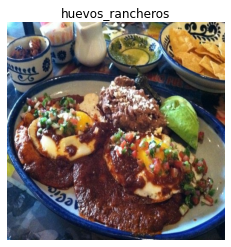

In [23]:
#Plot this picture
plt.imshow(image)
plt.title(labels[label.numpy()])
plt.axis(False)

### Make a function for preprocessing images
Our images have dtype uint8, but our model needs float32

In [24]:
def prep_img(img, label, img_shape = 224):
  """
  Convert image datatype tp float32 and reshapes to [img_shape, img_shape, color]
  """
  img = tf.image.resize(img, [img_shape, img_shape])
  img = tf.cast(img, dtype = tf.float32)
  return img, label

In [25]:
img, label = prep_img(image, label)

In [26]:
img.shape, img

(TensorShape([224, 224, 3]),
 <tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[230.65816  , 253.64285  , 251.       ],
         [222.99998  , 254.97449  , 252.19388  ],
         [207.06633  , 255.       , 250.36734  ],
         ...,
         [140.66287  , 129.52519  , 121.22428  ],
         [121.14268  , 115.26515  , 116.95397  ],
         [ 83.95363  ,  83.08119  ,  89.63737  ]],
 
        [[221.47449  , 254.37755  , 253.33163  ],
         [214.5102   , 255.       , 253.92348  ],
         [198.41327  , 254.58673  , 251.96939  ],
         ...,
         [208.66318  , 195.82143  , 173.40823  ],
         [197.03056  , 190.1071   , 174.83162  ],
         [175.54036  , 171.6169   , 161.21384  ]],
 
        [[204.21428  , 253.42857  , 249.57143  ],
         [198.71428  , 254.64287  , 251.2449   ],
         [185.04591  , 251.73979  , 252.21428  ],
         ...,
         [222.45403  , 207.47444  , 169.35715  ],
         [216.52551  , 205.01024  , 172.02556  ],
         [215.515

### Batch and prepare datasets

In [27]:
#Map preprocessing function
train_data = train_data_.map(map_func=prep_img, num_parallel_calls=tf.data.AUTOTUNE) #num_parallel_calls=tf.data.AUTOTUNE to get all computing resurses
#Make butches and shuffle again
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size = 32).prefetch(buffer_size = tf.data.AUTOTUNE)

In [28]:
#Same with test data, but without shuffle
test_data = test_data_.map(map_func=prep_img, num_parallel_calls=tf.data.AUTOTUNE)
test_data = test_data.batch(batch_size = 32).prefetch(buffer_size = tf.data.AUTOTUNE)


In [29]:
train_data, test_data

(<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>,
 <PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>)

### Create callback functions

In [30]:
import datetime

def create_checkpoint(model_name):
  """Returns checkpoint callback function, args: model number"""
  checkpoint_filepath = 'checkpoints/checkpoint_'+model_name+'.ckpt'
  model_checkpoints = tf.keras.callbacks.ModelCheckpoint(checkpoint_filepath, monitor='val_loss', verbose=1, save_best_only=True,
                                                          save_weights_only=True, save_freq='epoch',
                                                          options=None)
  return model_checkpoints

def create_tf_board_callback(dir_name, experiment_name):
  log_dir = dir_name + '/' + experiment_name + '/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
  tensorflow_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f'Saving TensorBoard log files to {log_dir}')
  return tensorflow_callback

def early_stopping():
  return tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                          min_delta=0, 
                                          patience=3, #if 3 epochs no improve it will stop
                                          verbose=1,
                                          mode='auto', 
                                          baseline=None, 
                                          restore_best_weights=True)

# Creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=2, #if 2 epochs no improve it will reduce LR
                                                 verbose=1, # print out when learning rate goes down 
                                                 min_lr=1e-7)  

### Set up mixed precision training

In [31]:
import tensorflow
tensorflow.__version__

'2.4.1'

In [32]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


### Building feature extraction model

In [33]:
base_model = EfficientNetB0(include_top=False)
base_model.trainable = False

16711680/16705208 [==============================] - 0s 0us/step


In [34]:
inputs = Input(shape = (224,224,3), name = 'input_layer')
gap_layer = GlobalAveragePooling2D(name = 'global_average_pooling')
dense = Dense(len(labels))
outputs = Activation(activation = 'softmax', dtype = tf.float32, name = 'output')

In [35]:
x = base_model(inputs, training = False)
x = gap_layer(x)
x = dense(x)
outputs = outputs(x)
model = Model(inputs, outputs)

In [36]:
model.compile(loss = 'sparse_categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])

In [37]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling (Glob (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 101)               129381    
_________________________________________________________________
output (Activation)          (None, 101)               0         
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


In [38]:
for layer in model.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "mixed_float16">
global_average_pooling True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
output True float32 <Policy "float32">


In [39]:
history_features = model.fit(train_data,
                             epochs = 3,
                             validation_data = test_data,
                             steps_per_epoch = len(train_data),
                             validation_steps = int(0.15*len(test_data)),
                             callbacks = [create_checkpoint('feature_extr_1'),
                                          early_stopping(),
                                          create_tf_board_callback('efficientnetB0_full', 'feature_extr')])

Saving TensorBoard log files to efficientnetB0_full/feature_extr/20210629-101729
Epoch 1/3
2368/2368 [==============================] - 247s 88ms/step - loss: 2.3247 - accuracy: 0.4651 - val_loss: 1.2332 - val_accuracy: 0.6724

Epoch 00001: val_loss improved from inf to 1.23324, saving model to checkpoints/checkpoint_feature_extr_1.ckpt
Epoch 2/3
2368/2368 [==============================] - 199s 83ms/step - loss: 1.3298 - accuracy: 0.6561 - val_loss: 1.1292 - val_accuracy: 0.6978

Epoch 00002: val_loss improved from 1.23324 to 1.12922, saving model to checkpoints/checkpoint_feature_extr_1.ckpt
Epoch 3/3
2368/2368 [==============================] - 179s 72ms/step - loss: 1.1662 - accuracy: 0.6951 - val_loss: 1.0912 - val_accuracy: 0.7084

Epoch 00003: val_loss improved from 1.12922 to 1.09119, saving model to checkpoints/checkpoint_feature_extr_1.ckpt


In [40]:
result_feature_extr = model.evaluate(test_data)
result_feature_extr

790/790 [==============================] - 59s 74ms/step - loss: 1.0930 - accuracy: 0.7050


[1.0929746627807617, 0.7049900889396667]

loss: 1.0930 - accuracy: 0.7050

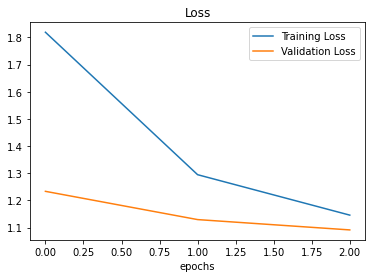

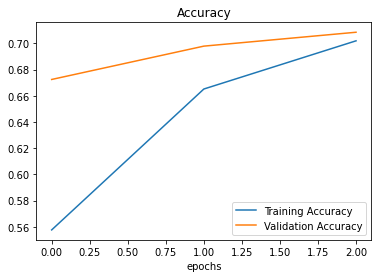

In [45]:
plot_loss_curves(history_features)

In [44]:
model.save('/content/drive/MyDrive/projects/SPICED/models/model_food101_feature_extr_5e')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/projects/SPICED/models/model_food101_feature_extr_5e/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/projects/SPICED/models/model_food101_feature_extr_5e/assets


### Fine tuning our model 25% layers in base model unfrozen for 25 epochs

I will also use callback function to decrease learning rate on plateau

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/projects/SPICED/models/model_food101_feature_extr_5e')

In [53]:
base_model.trainable = True
l = int(0.25*len(base_model.layers))
for layer in base_model.layers[:-l]:
  layer.trainable = False

In [54]:
for layer in base_model.layers:
  print(layer.name, layer.trainable)

input_1 False
rescaling False
normalization False
stem_conv_pad False
stem_conv False
stem_bn False
stem_activation False
block1a_dwconv False
block1a_bn False
block1a_activation False
block1a_se_squeeze False
block1a_se_reshape False
block1a_se_reduce False
block1a_se_expand False
block1a_se_excite False
block1a_project_conv False
block1a_project_bn False
block2a_expand_conv False
block2a_expand_bn False
block2a_expand_activation False
block2a_dwconv_pad False
block2a_dwconv False
block2a_bn False
block2a_activation False
block2a_se_squeeze False
block2a_se_reshape False
block2a_se_reduce False
block2a_se_expand False
block2a_se_excite False
block2a_project_conv False
block2a_project_bn False
block2b_expand_conv False
block2b_expand_bn False
block2b_expand_activation False
block2b_dwconv False
block2b_bn False
block2b_activation False
block2b_se_squeeze False
block2b_se_reshape False
block2b_se_reduce False
block2b_se_expand False
block2b_se_excite False
block2b_project_conv False
blo

In [55]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss = 'sparse_categorical_crossentropy',
              metrics = 'accuracy')

In [56]:
history_fine_tuned = model.fit(train_data, epochs = 28,
                               initial_epoch = 3,
                               validation_data = test_data,
                               steps_per_epoch = len(train_data),
                               validation_steps = int(0.15*len(test_data)),
                               callbacks = [create_checkpoint('fine_tune'),
                                          early_stopping(),
                                          create_tf_board_callback('efficientnetB0_full', 'fine_tune'),
                                          reduce_lr])

Saving TensorBoard log files to efficientnetB0_full/fine_tune/20210629-111705
Epoch 4/28
2368/2368 [==============================] - 312s 126ms/step - loss: 1.0096 - accuracy: 0.7310 - val_loss: 0.8145 - val_accuracy: 0.7733

Epoch 00004: val_loss improved from inf to 0.81452, saving model to checkpoints/checkpoint_fine_tune.ckpt
Epoch 5/28
2368/2368 [==============================] - 297s 122ms/step - loss: 0.6101 - accuracy: 0.8303 - val_loss: 0.8620 - val_accuracy: 0.7709

Epoch 00005: val_loss did not improve from 0.81452
Epoch 6/28
2368/2368 [==============================] - 290s 122ms/step - loss: 0.3485 - accuracy: 0.9030 - val_loss: 0.9340 - val_accuracy: 0.7778

Epoch 00006: val_loss did not improve from 0.81452

Epoch 00006: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
Epoch 7/28
2368/2368 [==============================] - 291s 122ms/step - loss: 0.1271 - accuracy: 0.9659 - val_loss: 0.9918 - val_accuracy: 0.8011

Epoch 00007: val_loss did not improv

In [57]:
result_fine_tuned = model.evaluate(test_data)
result_fine_tuned

790/790 [==============================] - 58s 73ms/step - loss: 0.8080 - accuracy: 0.7746


[0.8080074787139893, 0.7746138572692871]

### We beated results!
Our accuracy is higher then 77.4%
Model saved weights from 4 epoch, where we had best val_loss

3
7
[0.5576501488685608, 0.6651220917701721, 0.7018746137619019, 0.7515511512756348, 0.8427326679229736, 0.9130693078041077, 0.9781386256217957]


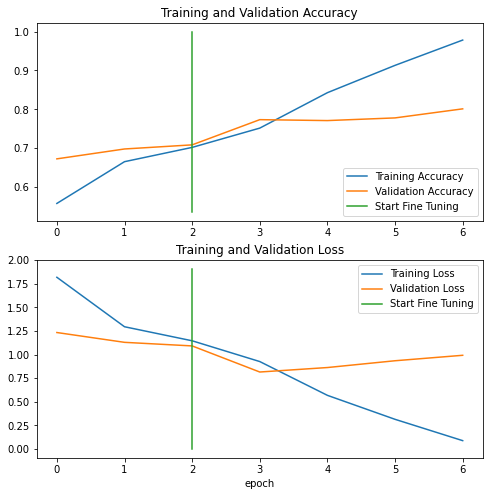

In [59]:
#History of feature extraction and fine tuning models
compare_historys(history_features, history_fine_tuned, initial_epochs=3)

In [62]:
model.save('/content/drive/MyDrive/projects/SPICED/models/model_food101_fine_tuned_28e')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/projects/SPICED/models/model_food101_fine_tuned_28e/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/projects/SPICED/models/model_food101_fine_tuned_28e/assets


### View training results on TensorBoard

In [ ]:
!tensorboard dev upload --logdir ./efficientnetB0_full \
  --name "Fine-tuning EfficientNetB0 on all Food101 Data" \
  --description "Training results for fine-tuning EfficientNetB0 on Food101 Data" \
  --one_shot

Done. View your TensorBoard at https://tensorboard.dev/experiment/SQ6lHb2dR06Mbm4Qmc9yLw/

### Make predictions and evaluate our model

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/projects/SPICED/models/model_food101_fine_tuned_28e')

In [70]:
model.evaluate(test_data)

790/790 [==============================] - 48s 59ms/step - loss: 0.8080 - accuracy: 0.7746


[0.8080074787139893, 0.7746138572692871]

In [64]:
pred_probs = model.predict(test_data)

In [65]:
preds = np.array(tf.argmax(pred_probs, axis = 1))

### Get labels

In [67]:
labels_test = []
for img, label in test_data.unbatch():
  labels_test.append(label.numpy())


In [68]:
np.array(labels_test[50:100])

array([ 98,  40,  60,  13,  36,  92,  21,  25,  29,  81,  66,  81,   1,
        92,  83,  16,  60,  32,  36,  94,  48,   0,  65,  29,  56,  37,
        87,  65,  64,  26,   1,  75,  61,  74,  54,  76,  34,  90,  15,
         4,  15,  19,  49, 100,  93,  62,  37,  99,  40,  60])

In [69]:
preds[50:100]

array([ 98,  40,  60,  13,  11,  57,  21,  25,  29,  64,  51,  81,   1,
        92,  83,  16,  60,  22,  36,  94,  48,  58,  65,  29,   9,  79,
        87,  65,  64,  99,  42,  75,  61,  74,  54,  76,  34,  90,  15,
         4,  44,  19,   4, 100,  50,  62,  37,  99,  40,  60])

### Plot confusion matrix

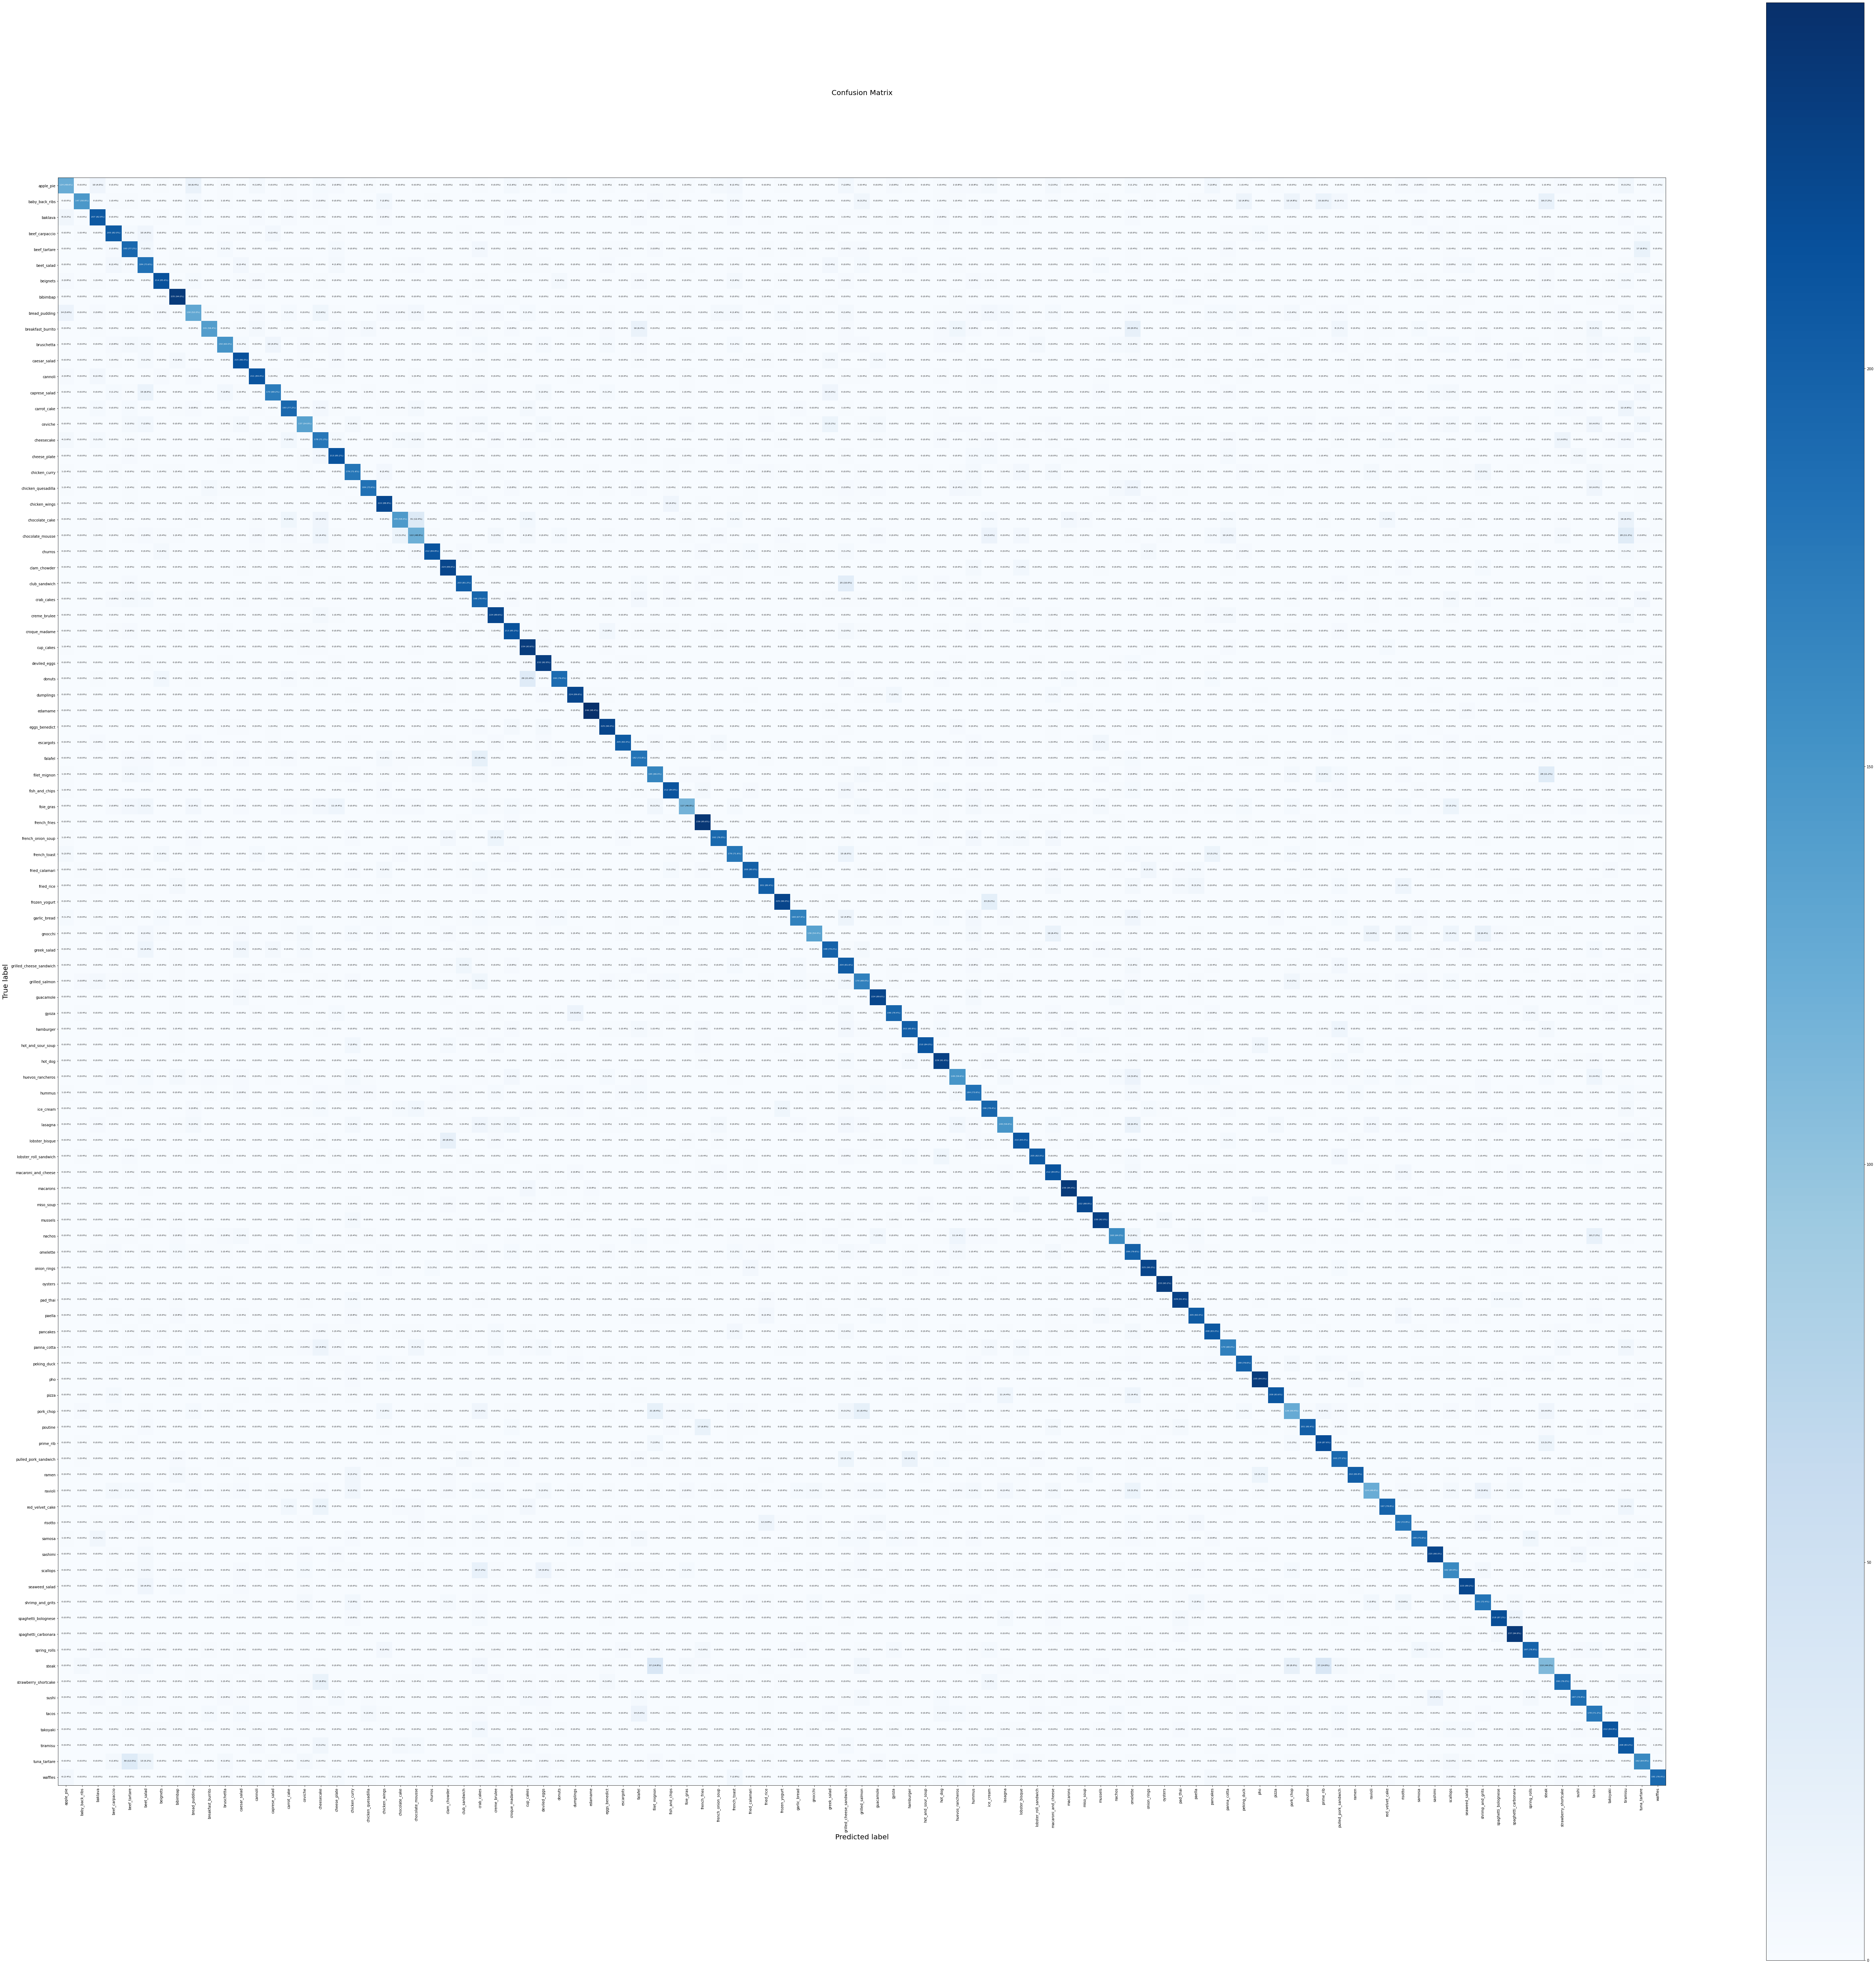

In [71]:
plot_confusion_matrix(preds, labels_test, figsize = (100,100), classes = labels)

### Classification report

In [72]:
from sklearn.metrics import classification_report

In [73]:
class_report = classification_report(y_test, preds, output_dict=True)

NameError: ignored

In [ ]:
report = {}
for key, item in class_report.items():
  if key == 'accuracy':
    break
  report[key] = [labels[int(key)], round(item['f1-score'],2)]

In [ ]:
report_df = pd.DataFrame.from_dict(report, orient='index', columns = ['name', 'f1-score'])
report_df = report_df.sort_values('f1-score', ascending = True)
report_df

### Plot class report

In [ ]:
fig, ax = plt.subplots(figsize=(15, 25))

scores = ax.barh(np.arange(len(report_df)), report_df['f1-score'], align='center')
ax.set_yticks(np.arange(len(report_df)))
ax.set_yticklabels(report_df['name'])
# ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Performance')
ax.set_title('Our model performance F1-score')

def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
      width = rect.get_width()
      ax.text(1.03*width, rect.get_y(), f"{width:.2f}", ha='center', va='bottom')

autolabel(scores)

plt.show()

### Plot random images from each class with predictions